1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [45]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [46]:
!date

Wed Feb  7 11:56:09 EST 2018


In [47]:
project_name='plant-seedlings-classification'

In [48]:
import os, sys

In [49]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [50]:
from fastai.conv_learner import *
import os

In [36]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

In [37]:
! pwd

/home/paperspace/fastai/courses/dl1


## Get data

### Directory based structure

In [38]:
!ls {PATH}

lr_plot.png  sample_submission.csv.zip	tmp    train.zip
models	     test			train  valid


In [39]:
notebook_dir = os.getcwd()
notebook_dir

'/home/paperspace/fastai/courses/dl1'

In [40]:
os.chdir(PATH)

In [41]:
! pwd

/home/paperspace/data/seeds


In [ ]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [42]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [43]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['c9b1820d0.png',
 '5c7abc049.png',
 '9d588ace5.png',
 '3ad5d809c.png',
 'b496ed692.png',
 '084d21b80.png',
 'a5c2eec2d.png',
 '85ae913c3.png',
 '66e90b455.png',
 '266211c3c.png']

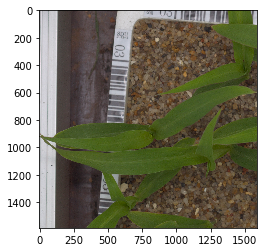

In [44]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [51]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1588, 1588, 3)

In [52]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['16e38d4af.png',
 '69f06fcbc.png',
 '7446f241c.png',
 '50c80a5e4.png',
 '8bfe6860d.png',
 '18b6755a1.png',
 '55083690a.png',
 '3ef465952.png',
 '606d5c83f.png',
 'ff4b55219.png']

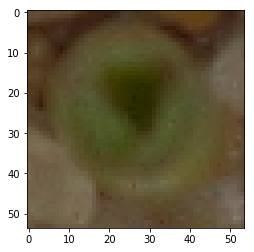

In [53]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [54]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(54, 54, 3)

In [55]:
os.chdir(notebook_dir)

In [56]:
! pwd

/home/paperspace/fastai/courses/dl1


In [57]:
arch=resnet34
size=100
bs=64 # default
#metrics=[f2]

In [58]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [59]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_top_down)

In [60]:
def get_aug_tfms(f_model, size, zoom): return tfms_from_model(f_model, size, aug_tfms=transforms_top_down, max_zoom=zoom)

In [61]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg', bs=bs)

In [62]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test', bs=bs)

# Enable data augmentation, and precompute=True

## Initial model setup

In [65]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.3))
data = data.resize(int(size*1.5), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [66]:
learn = ConvLearner.pretrained(arch, data)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [67]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 62/67 [00:06<00:00,  9.60it/s, loss=10.6]


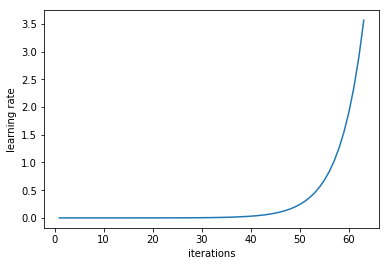

In [68]:
learn.sched.plot_lr()

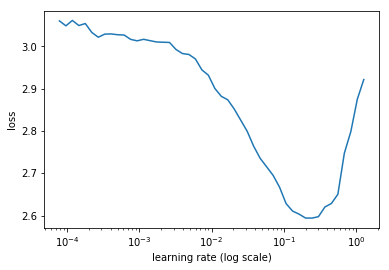

In [69]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [70]:
#learning_rate = 0.15 - best results thus far with 60/150/300
learning_rate = 0.1
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.916833   1.282749   0.594329  
    1      1.644527   1.170079   0.605324                 
    2      1.241413   1.021135   0.669271                 
    3      1.170891   1.053817   0.630932                 
    4      1.048773   0.895004   0.700738                 
    5      0.897879   0.851358   0.723669                  
    6      0.7988     0.827686   0.728805                  

CPU times: user 1min 35s, sys: 16.9 s, total: 1min 52s
Wall time: 53.9 s


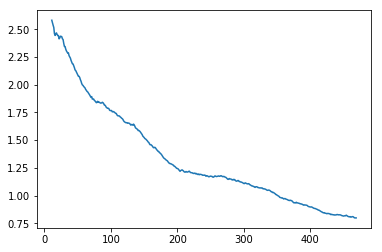

In [71]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.924247   0.497131   0.8091    
    1      0.616355   0.659159   0.778573                  
    2      0.370174   0.258846   0.90748                   
    3      0.388629   1.670683   0.644604                  
    4      0.277951   0.238729   0.928964                  
    5      0.156915   0.188993   0.951172                  
    6      0.097008   0.179858   0.955078                   

CPU times: user 2min 38s, sys: 41.2 s, total: 3min 19s
Wall time: 2min 20s


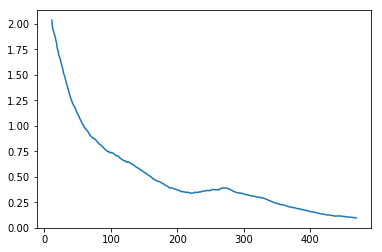

In [72]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [92]:
size = 150
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.1))
data = data.resize(int(size*1.1), 'tmp')
learn.set_data(data)


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.247872   0.27199    0.909433  
    1      0.220425   0.244682   0.921875                  
    2      0.202143   0.244628   0.919922                  
    3      0.215185   0.241967   0.919922                  
    4      0.19928    0.235845   0.919922                  
    5      0.185928   0.218726   0.927734                  
    6      0.174014   0.219664   0.927734                  

CPU times: user 2min 17s, sys: 24.2 s, total: 2min 41s
Wall time: 1min 18s


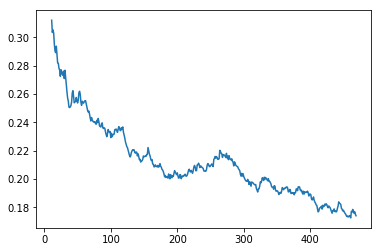

In [93]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.316197   0.215201   0.934823  
    1      0.268731   0.27441    0.921152                  
    2      0.152745   0.131374   0.958984                  
    3      0.17524    0.328934   0.914569                  
    4      0.149178   0.244755   0.921152                  
    5      0.07834    0.150793   0.958984                   
    6      0.036661   0.12496    0.962891                   

CPU times: user 4min 10s, sys: 1min 9s, total: 5min 20s
Wall time: 3min 56s


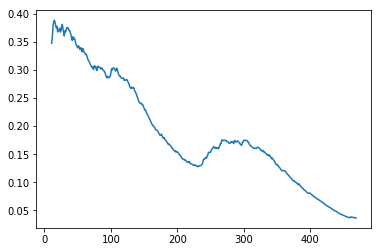

In [94]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [95]:
size = 300
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.389243   0.286959   0.898944  
    1      0.322741   0.250589   0.911386                  
    2      0.271435   0.233817   0.925781                  
    3      0.273522   0.223079   0.927011                  
    4      0.23836    0.211019   0.930194                  
    5      0.216193   0.194545   0.941406                  
    6      0.204574   0.190683   0.930917                  

CPU times: user 11min 55s, sys: 2min 8s, total: 14min 4s
Wall time: 5min 24s


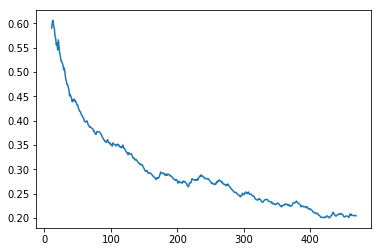

In [96]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.322625   0.166663   0.958984  
    1      0.258289   0.207603   0.932147                  
    2      0.141331   0.088994   0.980469                  
    3      0.167502   0.277518   0.905527                  
    4      0.118876   0.12528    0.966797                  
    5      0.064369   0.086653   0.980469                   
    6      0.037973   0.081342   0.982422                   

CPU times: user 18min 17s, sys: 4min 24s, total: 22min 42s
Wall time: 14min 4s


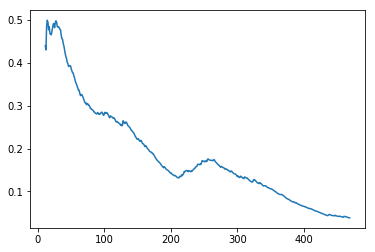

In [97]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [64]:
size = 500
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05))
data = data.resize(int(size*0.6), 'tmp')
learn.set_data(data)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [65]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)
# %time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=3)


learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.132976   0.13939    0.952402  
    1      0.106778   0.128262   0.956308                  
    2      0.093667   0.123304   0.960214                   
    3      0.090698   0.128815   0.958261                   
    4      0.091014   0.12009    0.958261                   
    5      0.079372   0.118116   0.968027                   
    6      0.077015   0.117257   0.962167                   

CPU times: user 19min 26s, sys: 6min 30s, total: 25min 57s
Wall time: 16min 53s


In [ ]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [ ]:
size = 600

data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05))
data = data.resize(int(size*0.6), 'tmp')
learn.set_data(data)

In [ ]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

In [ ]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [98]:
log_preds, y = learn.TTA()

In [99]:
log_preds.shape

(5, 475, 12)

In [100]:
log_preds[:,0,:]

array([[ -0.2751 , -11.39936, -11.31902,  -9.80573,  -7.69537,  -9.93217,  -1.42816, -10.90923,  -9.66201,
        -11.83393,  -9.47906, -11.5784 ],
       [ -0.2751 , -11.39936, -11.31902,  -9.80573,  -7.69537,  -9.93217,  -1.42816, -10.90923,  -9.66201,
        -11.83393,  -9.47906, -11.5784 ],
       [ -0.2751 , -11.39936, -11.31902,  -9.80573,  -7.69537,  -9.93217,  -1.42816, -10.90923,  -9.66201,
        -11.83393,  -9.47906, -11.5784 ],
       [ -0.2751 , -11.39936, -11.31902,  -9.80573,  -7.69537,  -9.93217,  -1.42816, -10.90923,  -9.66201,
        -11.83393,  -9.47906, -11.5784 ],
       [ -0.2751 , -11.39936, -11.31902,  -9.80573,  -7.69537,  -9.93217,  -1.42816, -10.90923,  -9.66201,
        -11.83393,  -9.47906, -11.5784 ]], dtype=float32)

In [101]:
y.shape

(475,)

In [102]:
y[15:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [103]:
y.max()

11

In [104]:
probs = np.mean(np.exp(log_preds), 0)

In [105]:
probs.shape

(475, 12)

In [106]:
probs[0,:]

array([0.75949, 0.00001, 0.00001, 0.00006, 0.00045, 0.00005, 0.23975, 0.00002, 0.00006, 0.00001, 0.00008,
       0.00001], dtype=float32)

In [107]:
accuracy_np(probs, y)

0.9810526315789474

In [108]:
from sklearn.metrics import f1_score

In [109]:
probs_idx = np.argmax(probs, axis=1)
probs_idx.shape

(475,)

In [110]:
f1_score(y, probs_idx, average='macro')

0.9759657573681965

In [111]:
f1_score(y, probs_idx, average='micro') # kaggle

0.9810526315789474

In [112]:
f1_score(y, probs_idx, average='weighted')

0.9810428102777269

### Confusion matrix

In [113]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, np.argmax(probs, axis=1))

In [114]:
plot_confusion_matrix(cm, data.classes)

NameError: name 'plot_confusion_matrix' is not defined

## Test set

In [115]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [116]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy_np(test_probs, test_y))

0.055415617128463476                         


In [117]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, :])

(794, 12)
[[0.1153  0.00012 0.00052 0.00005 0.88146 0.00027 0.00188 0.00013 0.00008 0.      0.00005 0.00014]
 [0.      0.00001 0.00001 0.      0.      0.      0.      0.      0.      0.00001 0.99997 0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.      0.      0.      0.     ]]
[0.1153  0.00012 0.00052 0.00005 0.88146 0.00027 0.00188 0.00013 0.00008 0.      0.00005 0.00014]


In [118]:
print(test_y.shape)
print(test_y[:4])
print(test_y[0,:])
print(test_y.max())

(794, 1)
[[0.]
 [0.]
 [0.]
 [0.]]
[0.]
0.0


In [119]:
test_y = np.argmax(test_probs, axis=1)
print(test_y.shape)
print(test_y[:4])
print(test_y.max())

(794,)
[ 4 10 10  7]
11


In [120]:
print(accuracy_np(test_probs, test_y))

1.0


In [121]:
class_indexes = np.argmax(test_probs, axis=1)

In [122]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [123]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [124]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [125]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], dtype='<U13')

In [126]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], dtype='<U25')

In [127]:
!pwd

/home/paperspace/fastai/courses/dl1


In [128]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [129]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-07 12:48:29.225320.csv

In [130]:
!date

Wed Feb  7 12:48:29 EST 2018
